# v4.1  of ParamGen notebook
## v2.0
Adjustment in typical_range & full_range based on preliminary NSE analysis
Adjustment in stratified_sampling_for_dependent_param(args)->constrained_sample(args): logics to add more randomness
Setting of constrained_sample(args): constraint multipliers are adjusted to cover parameter space a bit better
Targetting 1,000 ~ 5,000 parameter-sets
## v3.0
1. Sobol version, as LHS is slacking.
## v4.0 & v4.1
Dependent parameter high value problem
## v5.0
Kf_fast and Kf_slow is separeted.
Added preferred range.
## v6.0
Beta is separated and constrained.

In [1]:
import numpy as np
from scipy.stats import norm
import os

#from pyDOE import lhs

In [81]:
parameter_names = ['beta_W', 'beta_P', 'beta_H', 'D_H', 'D_P', 'KfW', 'KfaP', 'KfH', 'KfP', 'Sumax_W', 'Sumax_H', 'Sumax_P', 'TfW', 'Tfa', 'TfH', 'TfP']

full_range = {
    'beta_W': {'min': 0.01, 'max': 4},
    'beta_H': {'min': 0.01, 'max': 5},
    'beta_P': {'min': 0.01, 'max': 4.5},
    'D_H': {'min': 0.05, 'max': 1},
    'D_P': {'min': 0.1, 'max': 1},
    'KfW': {'min': 0.1, 'max': 1}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.1, 'max': 1}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.005, 'max': 0.25}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_H': {'min': 50, 'max': 750},
    'Sumax_P': {'min': 50, 'max': 1000},
    'TfW': {'min': 0, 'max': 3},
    'Tfa': {'min': 0, 'max': 3},
    'TfH': {'min': 1, 'max': 5},
    'TfP': {'min': 2, 'max': 5},
}

# There was no point of setting typical range.
KfLimit_range = {
    'beta_W': {'min': 0.01, 'max': 4},
    'beta_H': {'min': 0.01, 'max': 5},
    'beta_P': {'min': 0.01, 'max': 4.5},
    'D_H': {'min': 0.05, 'max': 1},
    'D_P': {'min': 0.1, 'max': 1},
    'KfW': {'min': 0.04, 'max': 0.1}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.04, 'max': 0.1}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.005, 'max': 0.1}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_H': {'min': 50, 'max': 1000},
    'Sumax_P': {'min': 50, 'max': 1000},
    'TfW': {'min': 0, 'max': 3},
    'Tfa': {'min': 0, 'max': 3},
    'TfH': {'min': 1, 'max': 5},
    'TfP': {'min': 2, 'max': 5},
}

preferred_range = {
    'beta_W': {'min': 0.01, 'max': 1},
    'beta_H': {'min': 0.01, 'max': 1.96},
    'beta_P': {'min': 0.01, 'max': 1.4},
    'D_H': {'min': 0.1, 'max': 0.4},
    'D_P': {'min': 0.2, 'max': 0.8},
    'KfW': {'min': 0.25, 'max': 0.5}, # allowing it to be very fast, as we are looking into smaller watersheds after all.
    'KfaP': {'min': 0.25, 'max': 0.5}, # Lower and upper limit constrained by KfW (0.5 * KfW <= KfaP <= KfW). Placeholder default values.
    'KfH': {'min': 0.04, 'max': 0.12}, # Lower limit constrained by KfP. Upper limit can be also constrained by KfaP. Placeholder default values.
    'KfP': {'min': 0.002, 'max': 0.02},
    'Sumax_W': {'min': 35, 'max': 500},
    'Sumax_H': {'min': 50, 'max': 750},
    'Sumax_P': {'min': 50, 'max': 1000},
    'TfW': {'min': 1, 'max': 1},
    'Tfa': {'min': 1, 'max': 2},
    'TfH': {'min': 2, 'max': 3},
    'TfP': {'min': 2, 'max': 4},
}


# Sobol

In [94]:
import numpy as np
from scipy.stats import qmc

def joint_sobol_sampling(param_ranges, num_samples, decimals=3):
    """Generates Sobol samples for multiple parameters jointly."""
    num_params = len(param_ranges)
    sampler = qmc.Sobol(d=num_params, scramble=True)
    sobol_samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = {}

    # Initialize samples dictionary with arrays
    for param in param_ranges:
        samples[param] = np.zeros(num_samples)

    # Generate independent parameter samples first
    independent_params = ['beta_W', 'D_P', 'KfW', 'KfP', 'Sumax_W', 'TfW']
    for i, param in enumerate(independent_params):
        bounds = param_ranges[param]
        scaled_samples = sobol_samples[:, i] * (bounds['max'] - bounds['min']) + bounds['min']
        if param in ['TfW']:
            scaled_samples = np.round(scaled_samples).astype(int)
            scaled_samples = np.clip(scaled_samples, bounds['min'], bounds['max'])
        samples[param] = np.round(scaled_samples, decimals)

    # Now generate dependent parameter samples using the already sampled independent parameters
    dependent_order = ['beta_P', 'beta_H', 'D_H', 'KfaP', 'KfH', 'Sumax_H', 'Sumax_P', 'Tfa', 'TfH', 'TfP']
    dependent_params_indices = {
        'beta_P': len(independent_params),
        'beta_H': len(independent_params) + 1,
        'D_H': len(independent_params) + 2,
        'KfaP': len(independent_params) + 3,
        'KfH': len(independent_params) + 4,
        'Sumax_H': len(independent_params) + 5,
        'Sumax_P': len(independent_params) + 6,
        'Tfa': len(independent_params) + 7,
        'TfH': len(independent_params) + 8,
        'TfP': len(independent_params) + 9,
    }

    for param in dependent_order:
        dep_index = dependent_params_indices[param]
        bounds = param_ranges[param]
        if param == 'beta_P':
            min_vals = np.maximum(samples['beta_W'], bounds['min'])
            #max_vals = np.minimum(samples['beta_W'] * 1.25, bounds['max'])
            max_vals = np.minimum(samples['beta_W'] * 1.5, bounds['max'])
            if np.any(max_vals > 4.5):
                max_vals = 4.5
        elif param == 'beta_H':
            min_vals = np.maximum(samples['beta_P'], bounds['min'])
            max_vals = np.minimum(samples['beta_P'] * 1.25, bounds['max'])
            #if np.any(max_vals > 5):
             #   max_vals = 5
        elif param == 'D_H':
            min_vals = np.maximum(samples['D_P'] * 0.25, bounds['min'])
            max_vals = np.minimum(samples['D_P'], bounds['max'])
        elif param == 'KfaP':
            min_vals = np.maximum(samples['KfW'] * 0.75, bounds['min'])
            max_vals = np.minimum(samples['KfW'], bounds['max'])
        elif param == 'KfH':
            min_vals = np.maximum(samples['KfP'], bounds['min'])
            max_vals = np.minimum(samples['KfaP'] * 0.5, bounds['max'])
        elif param == 'Sumax_H':
            min_vals = np.maximum(samples['Sumax_W'], bounds['min'])
            max_vals = np.minimum(samples['Sumax_W'] * 2, bounds['max'])
        elif param == 'Sumax_P':
            min_vals = np.maximum(samples['Sumax_H'], bounds['min'])
            max_vals = np.minimum(samples['Sumax_H'] * 2, bounds['max'])
        elif param == 'Tfa':
            min_vals = bounds['min']
            max_vals = bounds['max']
        elif param == 'TfH':
            min_vals = bounds['min']
            max_vals = bounds['max']
        elif param == 'TfP':
            min_vals = bounds['min']
            max_vals = bounds['max']
            
            # Scale the Sobol samples within the updated bounds
        scaled_samples = sobol_samples[:, dep_index] * (max_vals - min_vals) + min_vals

        if param in ['TfW', 'Tfa', 'TfH', 'TfP']:
            scaled_samples = np.floor(scaled_samples).astype(int)
            scaled_samples = np.clip(scaled_samples, bounds['min'], bounds['max'])

            if param == 'Tfa':
                scaled_samples = np.maximum(scaled_samples, samples['TfW'])
            elif param == 'TfH':
                scaled_samples = np.maximum(scaled_samples, samples['Tfa'])
            elif param == 'TfP':
                scaled_samples = np.maximum(scaled_samples, samples['TfH'])
        
            #scaled_samples = sobol_samples[:, dep_index % num_samples] * (max_vals - min_vals) + min_vals
        samples[param] = np.round(scaled_samples, decimals)

    return samples

# Beta constraining
Model performance declines noticeably when beta value exceeds 4.5

In [58]:
###Last charm>?
import numpy as np
import copy

def generate_samples_with_constraints(param_ranges_in, num_samples, threshold, max_percentage, decimals):
    """Generates samples ensuring the constraints on exceedance percentage."""
    param_ranges = copy.deepcopy(param_ranges_in)
    exceedance_limit = int(num_samples * max_percentage / 100)
    samples_accumulated = {param: [] for param in param_ranges}
    total_collected = 0
    total_exceeding = 0

    initial_max_beta_W = param_ranges['beta_W']['max']
    initial_max_beta_H = param_ranges['beta_H']['max']

    while total_collected < num_samples:
        remaining_samples = num_samples - total_collected
        samples = joint_sobol_sampling(param_ranges, remaining_samples, decimals)

        num_generated_samples = len(samples['beta_W'])

        # Calculate the number of exceedances for beta_W and beta_H
        beta_W_exceeding = np.sum(np.array(samples['beta_W']) > threshold)
        beta_H_exceeding = np.sum(np.array(samples['beta_H']) > threshold * 1.25)
        combined_exceeding = beta_W_exceeding + beta_H_exceeding

        if total_exceeding + combined_exceeding <= exceedance_limit:
            # Collect all samples
            for param in param_ranges:
                samples_accumulated[param].extend(samples[param])
            total_collected += num_generated_samples
            total_exceeding += combined_exceeding
        else:
            # Selectively accept samples to keep exceedance under limit
            for i in range(num_generated_samples):
                if total_exceeding < exceedance_limit:
                    if (samples['beta_W'][i] > threshold or samples['beta_H'][i] > threshold):
                        if (samples['beta_W'][i] > threshold and samples['beta_H'][i] > threshold * 1.25):
                            # If both exceed, count twice
                            if total_exceeding + 2 <= exceedance_limit:
                                for param in param_ranges:
                                    samples_accumulated[param].append(samples[param][i])
                                total_collected += 1
                                total_exceeding += 2
                        else:
                            # If only one exceeds
                            for param in param_ranges:
                                samples_accumulated[param].append(samples[param][i])
                            total_collected += 1
                            total_exceeding += 1
                    else:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1
                else:
                    if samples['beta_W'][i] <= threshold and samples['beta_H'][i] <= threshold * 1.25:
                        for param in param_ranges:
                            samples_accumulated[param].append(samples[param][i])
                        total_collected += 1

            # Gradually narrow parameter ranges dynamically
            if beta_W_exceeding + len(samples_accumulated['beta_W']) > exceedance_limit:
                current_max_beta_W = param_ranges['beta_W']['max']
                param_ranges['beta_W']['max'] = max(threshold, current_max_beta_W - 0.1 * (current_max_beta_W - threshold))
            if beta_H_exceeding + len(samples_accumulated['beta_H']) > exceedance_limit:
                current_max_beta_H = param_ranges['beta_H']['max']
                param_ranges['beta_H']['max'] = max(threshold, current_max_beta_H - 0.1 * (current_max_beta_H - threshold * 1.25))

    # Ensure all lists are exactly num_samples in length
    for param in samples_accumulated:
        samples_accumulated[param] = np.array(samples_accumulated[param][:num_samples])

    return samples_accumulated


## Wrapper for easy use

In [59]:
def generate_custom_samples(param_ranges, num_samples, decimals=4):
    """Generates samples considering direct relationships between parameters."""
    #independent_params = ['beta_W', 'D_H', 'KfW', 'KfP', 'Sumax_W']
    #independent_ranges = {param: param_ranges[param] for param in independent_params}
    # Generate joint Sobol samples for independent parameters with constraints
    threshold = 2.5
    max_percentage = 25
    samples = generate_samples_with_constraints(param_ranges, num_samples, threshold, max_percentage, decimals)
    #samples = joint_sobol_sampling(param_ranges, num_samples)

    samples['beta_W'] = samples['beta_W'].round(2)
    samples['beta_H'] = samples['beta_H'].round(2)
    samples['beta_P'] = samples['beta_P'].round(2)
    samples['D_H'] = samples['D_H'].round(3)
    samples['D_P'] = samples['D_P'].round(3)
    samples['KfW'] = samples['KfW'].round(3)
    samples['KfaP'] = samples['KfaP'].round(3)
    samples['KfH'] = samples['KfH'].round(4)
    samples['KfP'] = samples['KfP'].round(4)
    samples['Sumax_W'] = samples['Sumax_W'].round(0)
    samples['Sumax_H'] = samples['Sumax_H'].round(0)
    samples['Sumax_P'] = samples['Sumax_P'].round(0)

    ordered_samples = [{param: samples[param][i] for param in param_ranges} for i in range(num_samples)]
    return ordered_samples

# Test the defined functions

In [34]:
test = joint_sobol_sampling(full_range, 500)
test_df =  pd.DataFrame(test)
print(test_df.tail())

     beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP    KfH    KfP  \
251   4.654   4.902   4.876  0.440  0.749  0.453  0.411  0.180  0.003   
252   4.084   4.995   4.943  0.347  0.355  0.184  0.143  0.008  0.005   
253   1.356   1.574   1.526  0.348  0.637  0.749  0.673  0.169  0.014   
254   0.051   0.070   0.054  0.119  0.169  0.411  0.397  0.189  0.007   
255   2.935   4.228   3.756  0.593  0.786  0.972  0.815  0.095  0.017   

     Sumax_W  Sumax_HP  
251  480.099   692.028  
252  436.770   838.567  
253  265.955   394.340  
254   65.261    73.735  
255  359.669   871.596  


# Define some functions for evaluation

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parameter_distributions(samples, parameter_names):
    """
    Plots the distribution of each parameter using histograms.

    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to plot.
    """
    num_params = len(parameter_names)
    fig, axes = plt.subplots(num_params, 1, figsize=(10, 5 * num_params))
    
    if num_params == 1:
        axes = [axes]  # Make it iterable
    
    for ax, param in zip(axes, parameter_names):
        param_values = [sample[param] for sample in samples]
        ax.hist(param_values, bins=20, alpha=0.5, color='blue', density=True) #density = True?
        ax.set_title(f'Distribution of {param}')
        ax.set_xlabel(param)
        ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()


def calculate_coefficient_of_variation(samples, parameter_names):
    """
    Calculates and prints the Coefficient of Variation (CV) for each parameter.
    
    Args:
    - samples (list of dicts): The sampled parameter sets.
    - parameter_names (list of str): List of parameter names to calculate CV for.
    """
    for param in parameter_names:
        param_values = np.array([sample[param] for sample in samples])
        mean = np.mean(param_values)
        std_dev = np.std(param_values)
        cv = std_dev / mean if mean else 0  # Avoid division by zero
        print(f'Coefficient of Variation for {param}: {cv:.3f}')

# Actual sample generation

In [101]:
import pandas as pd

n_total = 1000
# Sample size
n_full = int(n_total * 0.6)
#n_typical = 100
n_preferred = int(n_total * 0.35)
n_KfLimit = int(n_total * 0.05)
# Generate custom samples
print(n_full, n_preferred, n_KfLimit)

np.random.seed(827)
full_custom_samples = generate_custom_samples(full_range, n_full)
KfLimit_custom_samples = generate_custom_samples(KfLimit_range, n_KfLimit)
preferred_custom_samples = generate_custom_samples(preferred_range, n_preferred)
#typical_custom_samples = generate_custom_samples(typical_range, n_typical)

combined_samples = full_custom_samples + KfLimit_custom_samples + preferred_custom_samples#+ typical_custom_samples
combined_samples_df =  pd.DataFrame(combined_samples)
print(combined_samples_df.tail())

600 350 50
     beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP     KfH     KfP  \
995    0.63    0.91    0.75  0.221  0.658  0.470  0.428  0.0987  0.0114   
996    0.81    1.32    1.16  0.184  0.312  0.335  0.331  0.1003  0.0102   
997    0.05    0.07    0.06  0.400  0.622  0.436  0.352  0.0547  0.0155   
998    0.74    0.87    0.76  0.160  0.629  0.470  0.455  0.0875  0.0199   
999    0.43    0.63    0.62  0.326  0.380  0.274  0.256  0.0682  0.0069   

     Sumax_W  Sumax_H  Sumax_P  TfW  Tfa  TfH  TfP  
995    224.0    419.0    799.0    1    1    2    2  
996     67.0    115.0    162.0    1    1    2    3  
997    466.0    524.0    854.0    1    1    2    2  
998    273.0    498.0    542.0    1    1    2    2  
999     50.0     53.0     94.0    1    1    2    3  


Coefficient of Variation for beta_W: 0.806
Coefficient of Variation for beta_P: 0.785
Coefficient of Variation for beta_H: 0.783
Coefficient of Variation for D_H: 0.586
Coefficient of Variation for D_P: 0.437
Coefficient of Variation for KfW: 0.515
Coefficient of Variation for KfaP: 0.516
Coefficient of Variation for KfH: 0.610
Coefficient of Variation for KfP: 0.470
Coefficient of Variation for Sumax_W: 0.509
Coefficient of Variation for Sumax_H: 0.508
Coefficient of Variation for Sumax_P: 0.492
Coefficient of Variation for TfW: 0.610
Coefficient of Variation for Tfa: 0.490
Coefficient of Variation for TfH: 0.335
Coefficient of Variation for TfP: 0.252


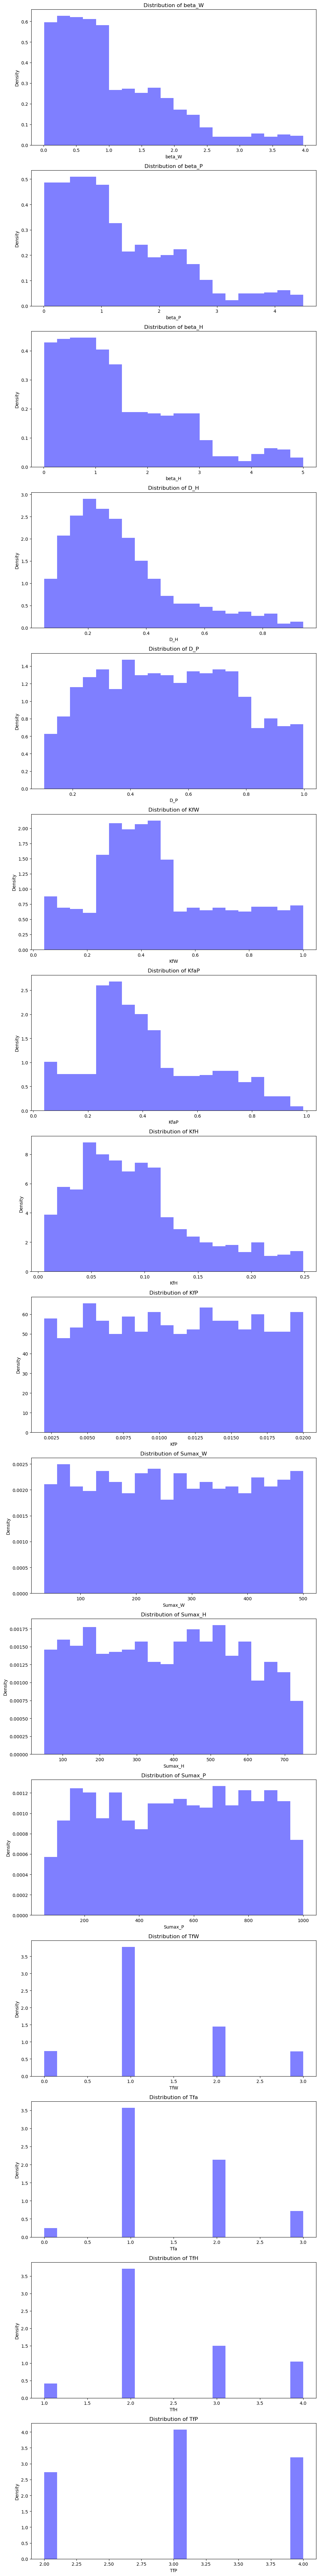

In [102]:
calculate_coefficient_of_variation(combined_samples, parameter_names)
plot_parameter_distributions(combined_samples, parameter_names)

# save the final outputs

In [103]:
# fulton ks_values = [0.0004, 0.001, 0.013]

# san diego ks_values = [0.0004, 0.0006, 0.007]
# san diego final Ks = 0.0002

ks_values = [0.0002]
df = pd.DataFrame(combined_samples)

# Create an empty dataframe to hold the new rows
expanded_df = pd.DataFrame()

# Repeat each row of the original dataframe three times with different 'Ks' values
for ks in ks_values:
    temp_df = df.copy()
    temp_df['Ks'] = ks
    expanded_df = pd.concat([expanded_df, temp_df], ignore_index=True)

print(expanded_df.tail())

     beta_W  beta_H  beta_P    D_H    D_P    KfW   KfaP     KfH     KfP  \
995    0.63    0.91    0.75  0.221  0.658  0.470  0.428  0.0987  0.0114   
996    0.81    1.32    1.16  0.184  0.312  0.335  0.331  0.1003  0.0102   
997    0.05    0.07    0.06  0.400  0.622  0.436  0.352  0.0547  0.0155   
998    0.74    0.87    0.76  0.160  0.629  0.470  0.455  0.0875  0.0199   
999    0.43    0.63    0.62  0.326  0.380  0.274  0.256  0.0682  0.0069   

     Sumax_W  Sumax_H  Sumax_P  TfW  Tfa  TfH  TfP      Ks  
995    224.0    419.0    799.0    1    1    2    2  0.0002  
996     67.0    115.0    162.0    1    1    2    3  0.0002  
997    466.0    524.0    854.0    1    1    2    2  0.0002  
998    273.0    498.0    542.0    1    1    2    2  0.0002  
999     50.0     53.0     94.0    1    1    2    3  0.0002  


In [104]:
wsName_list = ["san-diego_california_20331196_11023340",
               "fulton_georgia_2047963_02336410"
              ]

wsName = "san-diego_california_20331196_11023340"

os.chdir(os.path.join("D:\\", "wflow_models"))

expanded_df.to_csv(str('combined_samples_0708_' + wsName + '.csv'), index=False)

In [115]:
import os
import pandas as pd

#os.chdir('/mnt/c/Workspace/Ch3/wflow_models/')
os.chdir(os.path.join("D:\\", "wflow_models"))

# Convert the list of dictionaries into a DataFrame
#df = pd.DataFrame(combined_samples)

#print(df)
# Save the DataFrame to a CSV file
df.to_csv('combined_samples_v4_Ks.csv', index=False)

# OLD

In [ ]:
import numpy as np

def sample_parameters(defaults, range_constraints):
    params = {}
    for param, stats in defaults.items():
        mean, std = stats['mean'], stats['std']
        min_val, max_val = range_constraints[param]['min'], range_constraints[param]['max']
        
        # Sample within the specified range
        while True:
            sample = np.random.normal(mean, std)
            if min_val <= sample <= max_val:
                params[param] = sample
                break
    
    # Ensure relationships between parameters
    # This may need several iterations for all conditions to be satisfied
    satisfied = False
    while not satisfied:
        if params['beta_W'] > params['beta_HP']:
            params['beta_W'], params['beta_HP'] = np.random.normal(defaults['beta_W']['mean'], defaults['beta_W']['std']), np.random.normal(defaults['beta_HP']['mean'], defaults['beta_HP']['std'])
        
        if params['D_H'] >= params['D_P']:
            params['D_H'], params['D_P'] = np.random.normal(defaults['D_H']['mean'], defaults['D_H']['std']), np.random.normal(defaults['D_P']['mean'], defaults['D_P']['std'])
        
        if params['Kf_fast'] >= params['Kf_slow']:
            params['Kf_fast'], params['Kf_slow'] = np.random.normal(defaults['Kf_fast']['mean'], defaults['Kf_fast']['std']), np.random.normal(defaults['Kf_slow']['mean'], defaults['Kf_slow']['std'])
        
        if params['Sumax_W'] > params['Sumax_HP']:
            params['Sumax_W'], params['Sumax_HP'] = np.random.normal(defaults['Sumax_W']['mean'], defaults['Sumax_W']['std']), np.random.normal(defaults['Sumax_HP']['mean'], defaults['Sumax_HP']['std'])
        
        # Check if all relationships are satisfied
        satisfied = (params['beta_W'] <= params['beta_HP'] and
                     params['D_H'] < params['D_P'] and
                     params['Kf_fast'] < params['Kf_slow'] and
                     params['Sumax_W'] <= params['Sumax_HP'])
    
    return params

# Example usage
defaults = {
    'beta_W': {'mean': 0.27, 'std': 0.135},
    'beta_HP': {'mean': 0.27, 'std': 0.135},
    'D_H': {'mean': 0.24, 'std': 0.12},
    'D_P': {'mean': 0.24, 'std': 0.12},
    'Kf_fast': {'mean': 0.04, 'std': 0.02},
    'Kf_slow': {'mean': 0.005, 'std': 0.0025},
    'Sumax_W': {'mean': 100, 'std': 50},
    'Sumax_HP': {'mean': 250, 'std': 125}
}

range_constraints = {
    'beta_W': {'min': 0, 'max': 5},
    'beta_HP': {'min': 0, 'max': 5},
    'D_H': {'min': 0, 'max': 1},
    'D_P': {'min': 0, 'max': 1},
    'Kf_fast': {'min': 0.01, 'max': 0.08},
    'Kf_slow': {'min': 0.0008, 'max': 0.01},
    'Sumax_W': {'min': 5, 'max': 250},
    'Sumax_HP': {'min': 5, 'max': 500},
}

sample


2336410


/tmp/ipykernel_15557/1625775067.py:25: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
/tmp/ipykernel_15557/1625775067.py:26: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)


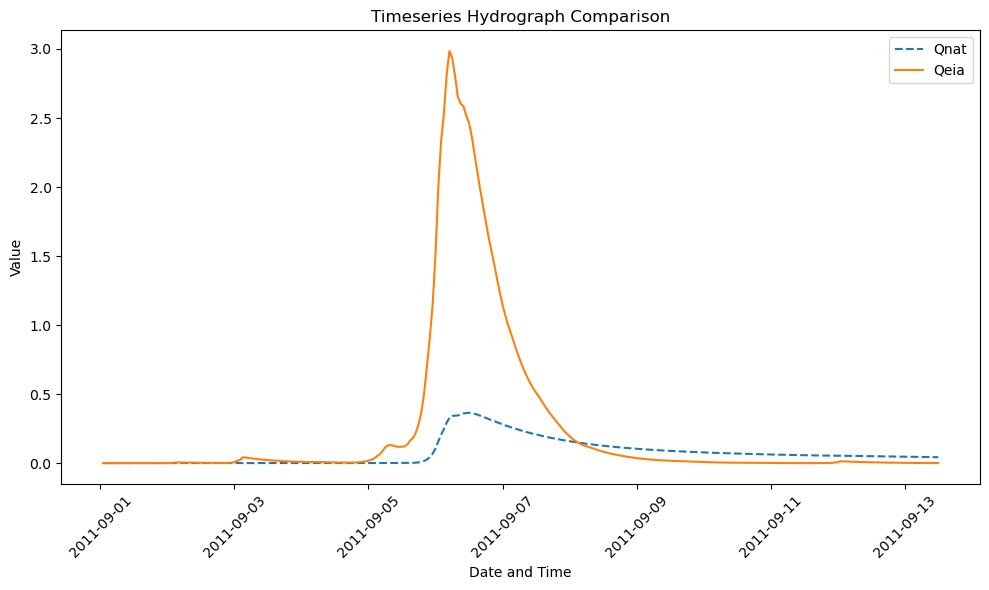

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


runId = "output/test_dt_Simp2"

outlet = str(int(wsName.split("_")[-1]))
print(outlet)

output_directory = str("../wflow_models/" +wsName + "/" + runId)

# Create a time series index
date_range = pd.date_range(start=datetimestart, periods=lastTimeStep + 1, freq=f'{timestepsecs}s')
date_range = date_range[:-1]

# Paths to the CSV files
#path0 = str(output_directory + '/Prec.csv')
path1 = str(output_directory + '/Qt.csv')
path2 = str(output_directory + '/Qeia.csv')



# Read the last column from both CSV files
df1 = pd.read_csv(path1, usecols=[outlet], squeeze=True)
df2 = pd.read_csv(path2, usecols=[outlet], squeeze=True)
#df3 = pd.read_csv(path3, usecols=['1401'], squeeze=True)
#df4 = pd.read_csv(path4, usecols=['1401'], squeeze=True)
#df5 = pd.read_csv(path5, usecols=['1401'], squeeze=True)
#df6 = pd.read_csv(path6, usecols=['1401'], squeeze=True)


# Assign the date_range as the index directly
df1.index = date_range
df2.index = date_range
#df3.index = date_range
#df4.index = date_range
#df5.index = date_range
#df6.index = date_range


# Ensure the lengths match, trimming if necessary (optional, remove if not needed)
df1 = df1.iloc[:len(date_range)]
df2 = df2.iloc[:len(date_range)]
#df3 = df3.iloc[:len(date_range)]
#df4 = df4.iloc[:len(date_range)]
#df5 = df5.iloc[:len(date_range)]
#df6 = df6.iloc[:len(date_range)]




# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1, label='Qnat', linestyle='--')
plt.plot(df2.index, df2, label='Qeia')
#plt.plot(df3.index, df3, label='BetaKf0Lumped', linestyle='--')
#plt.plot(df4.index, df4, label='Realistic', linestyle='--')
#plt.plot(df5.index, df5, label='None', linestyle='-.')
#plt.plot(df6.index, df6, label='BetaKf0Distributed', linestyle='-.')
plt.title('Timeseries Hydrograph Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
from pyDOE import lhs

# Define the number of samples
num_samples = 1000

# LHS sampling from a uniform distribution [0, 1) for each parameter (4 parameters in total)
uniform_samples = lhs(4, samples=num_samples)

# Default values and standard deviations for Gaussian transformation
defaults = {
    'beta': {'mean': 2.55, 'std': 1.275},  # Adjust mean and std according to your needs
    'D': {'mean': 0.5, 'std': 0.25},
    'Kf': {'mean': 0.0204, 'std': 0.01},
    'Sumax': {'mean': 350, 'std': 125},
}

# Parameter constraints (example values, adjust as needed)
constraints = {
    'beta_a': {'min': 0.1, 'max': 5},
    'D_b': {'min': 0, 'max': 1},
    'Kf_c': {'min': 0.0008, 'max': 0.04},
    'Sumax_d': {'min': 100, 'max': 600},
}

# Transform uniform LHS samples to Gaussian based on default values
gaussian_samples = np.zeros(uniform_samples.shape)
for i, (key, value) in enumerate(defaults.items()):
    gaussian_samples[:, i] = norm.ppf(uniform_samples[:, i], loc=value['mean'], scale=value['std'])

# Apply constraints (simple example, more complex logic might be required for your specific model)
# Ensure samples are within defined ranges
for i, (key, constraint) in enumerate(constraints.items()):
    gaussian_samples[:, i] = np.clip(gaussian_samples[:, i], constraint['min'], constraint['max'])

# For correlated parameters, like beta, enforce a = d < b = c through sorting or other logic
# This step is highly specific to your model's constraints and might need customization

# Example: Sorting the 'beta' and 'D' samples to enforce a simple constraint
# This is a placeholder step; replace with your specific constraints logic
gaussian_samples[:, [0, 1]] = np.sort(gaussian_samples[:, [0, 1]], axis=1)

# Output
print("Sample of transformed and constrained Gaussian LHS samples for each parameter:")
for i, param in enumerate(defaults.keys()):
    print(f"{param}: {gaussian_samples[:5, i]}")
